In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/spotify_genre')
images_dir = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img'

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from src.processing import *
from src.visualization import *
from src.spotify_api import *
from src.modeling import *

In [3]:
# Import artist and track data
tracks_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/data/tracks.csv'
artists_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/data/artists.csv'

tracks_raw = pd.read_csv(tracks_path)
artists_raw = pd.read_csv(artists_path)

# Verify data
print('{} artists'.format(artists_raw.shape[0]))
print('{} tracks'.format(tracks_raw.shape[0]))

1104349 artists
586672 tracks


In [4]:
# Copy and process raw artist and track data
artist_split = clean_artists(artists_raw)
tracks_split = clean_tracks(tracks_raw, max_artists=3)

# artist_split['genres'].value_counts()

1104349 total artists
298616 artists with labeled genres
459962 genre-artist pairs after processing
586672 total tracks
574073 tracks with 3 or fewer artists
689217 track-artist pairs after processing


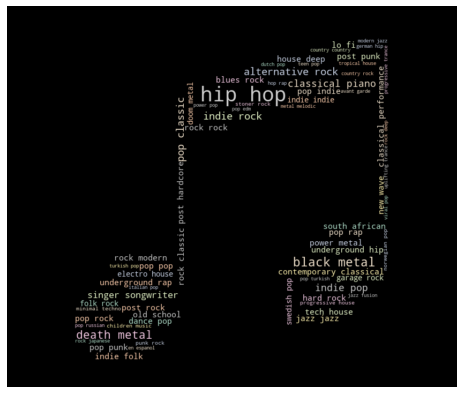

In [ ]:
# Word cloud generator

note_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img/note.png'

masked_wordcloud(artist_split, mask = note_path, name = 'note_cloud',
                 min_font = 8, colormap_choice='Pastel2')

# roam_4_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img/roam_4.png'
# masked_wordcloud(artist_split, mask = roam_4_path, name='roam_4', min_font = 0.1, colormap_choice='Pastel2')

In [5]:
# Merge artists and tracks according to desired genre specificity
total_genres = artist_split['genres'].nunique()
tracks_200_genres = top_x_genres(artist_split, tracks_split, num_genres=200)
tracks_500_genres = top_x_genres(artist_split, tracks_split, num_genres=500)


# Remove popular genres from datasets for "obscure" training options
tracks_200_genres_obscure = top_x_genres(artist_split, tracks_split, num_genres=200, obscurity=20)
tracks_500_genres_obscure = top_x_genres(artist_split, tracks_split, num_genres=500, obscurity=20)

1211852 tracks from top 200 genres
1619462 tracks from top 500 genres
905672 tracks from top 200 obscure genres
1285433 tracks from top 500 obscure genres


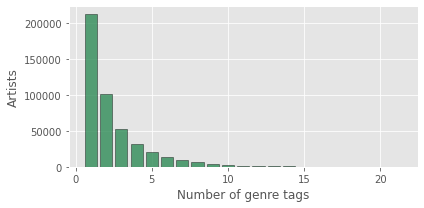

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img/'

bars = list(artist_split.genre_count.value_counts().index)
height = list(artist_split.genre_count.value_counts().values)

fig, ax = plt.subplots(figsize=(6,3))
# ax.hist(artist_split.genres.value_counts().values, color = 'seagreen', bins=80, alpha = 0.8, histtype='bar', ec='black')
ax.bar(bars, height,  color = 'seagreen', alpha=0.8,  ec='black')
ax.set_xlabel('Number of genre tags')
ax.set_ylabel('Artists')
# plt.title('Genre Association')
plt.tight_layout()
plt.savefig(f'{img_path}genre_artists_hist.png', dpi=300)

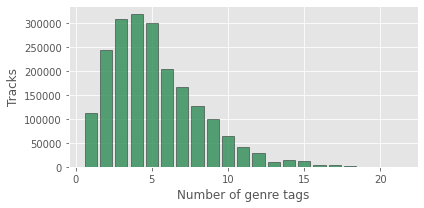

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/spotify_genre/img/'

bars = list(tracks_all_genres.genre_count.value_counts().index)
height = list(tracks_all_genres.genre_count.value_counts().values)

fig, ax = plt.subplots(figsize=(6,3))
ax.bar(bars, height,  color = 'seagreen', alpha=0.8,  ec='black')
ax.set_xlabel('Number of genre tags')
ax.set_ylabel('Tracks')
# plt.title('Genre Association')
plt.tight_layout()
plt.savefig(f'{img_path}genre_tracks_hist.png', dpi=300)

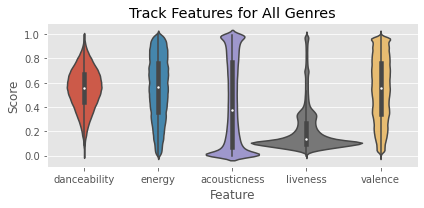

In [ ]:
# Violin plot for all tracks

tracks_all_features = tracks_all_genres[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence']]
tracks_all_features_subset = tracks_all_features[['danceability', 'energy', 'acousticness','liveness', 'valence']]

fig, ax = plt.subplots(figsize=(6,3))
ax = sns.violinplot(data=tracks_all_features_subset, width=1.5)
ax.set_xlabel('Feature')
ax.set_ylabel('Score')
# plt.xticks(rotation=30)
plt.title('Track Features for All Genres')
plt.tight_layout()
plt.savefig(f"{images_dir}/genre_violin_all.png", dpi=300)

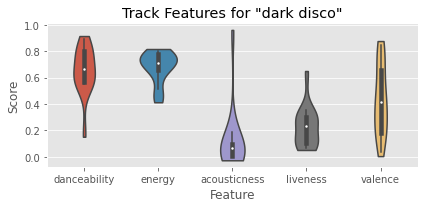

In [ ]:
# Violin plot for specific genre

tracks_rock = tracks_all_genres[tracks_all_genres['genres'] == 'dark disco']

tracks_rock_features = tracks_rock[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence']]

tracks_rock_features_subset = tracks_rock_features[['danceability', 'energy','acousticness', 'liveness', 'valence']]

fig, ax = plt.subplots(figsize=(6,3))
ax = sns.violinplot(data=tracks_rock_features_subset, width=0.5, cut=0.2)
ax.set_xlabel('Feature')
ax.set_ylabel('Score')
# plt.xticks(rotation=30)
plt.title('Track Features for "dark disco"')
plt.tight_layout()
plt.savefig(f"{images_dir}/genre_violin_dark_disco.png", dpi=300)

In [ ]:
tracks_1000_genres['genres'].value_counts()

rock                  32141
adult standards       27201
filmi                 26156
classic rock          23980
mellow gold           19738
                      ...  
swedish idol pop        297
lithuanian hip hop      296
free improvisation      296
italian pop rock        295
brazilian boogie        294
Name: genres, Length: 1000, dtype: int64

In [ ]:
tracks_all_genres.describe()


,followers,popularity_x,genre_count,popularity_y,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_count
count,2.055424e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06,2.055426e+06
mean,1.415010e+06,5.732182e+01,5.186169e+00,3.014425e+01,2.403164e+05,5.144530e-02,5.515120e-01,5.533942e-01,5.232922e+00,-1.013946e+01,6.614906e-01,7.325766e-02,4.272018e-01,1.286376e-01,2.117556e-01,5.466463e-01,1.191016e+02,3.891533e+00,1.314052e+00
std,4.103992e+06,1.552861e+01,2.919661e+00,1.853998e+01,1.191911e+05,2.209043e-01,1.674067e-01,2.560951e-01,3.510189e+00,5.144646e+00,4.732028e-01,8.963873e-02,3.524674e-01,2.802102e-01,1.870384e-01,2.589956e-01,2.937299e+01,4.195364e-01,5.885715e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.344000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,5.343700e+04,4.700000e+01,3.000000e+00,1.600000e+01,1.812800e+05,0.000000e+00,4.380000e-01,3.550000e-01,2.000000e+00,-1.279800e+01,0.000000e+00,3.390000e-02,7.180000e-02,0.000000e+00,9.700000e-02,3.390000e-01,9.629300e+01,4.000000e+00,1.000000e+00
50%,2.699580e+05,5.800000e+01,5.000000e+00,3.000000e+01,2.217070e+05,0.000000e+00,5.600000e-01,5.670000e-01,5.000000e+00,-9.157000e+00,1.000000e+00,4.330000e-02,3.720000e-01,7.270000e-05,1.350000e-01,5.580000e-01,1.179780e+02,4.000000e+00,1.000000e+00
75%,1.115094e+06,6.800000e+01,7.000000e+00,4.300000e+01,2.732000e+05,0.000000e+00,6.730000e-01,7.650000e-01,8.000000e+00,-6.396000e+00,1.000000e+00,6.840000e-02,7.710000e-01,2.400000e-02,2.700000e-01,7.650000e-01,1.366940e+02,4.000000e+00,1.000000e+00
max,7.890023e+07,1.000000e+02,2.100000e+01,1.000000e+02,4.995083e+06,1.000000e+00,9.910000e-01,1.000000e+00,1.100000e+01,5.376000e+00,1.000000e+00,9.660000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.435070e+02,5.000000e+00,3.000000e+00


In [ ]:
top_x_genres(artist_split, tracks_split, num_genres=50)

From 2055426 total tracks:  
 613420 tracks from top 50 genres


,id_x,followers,genres,name_x,popularity_x,genres_clean,genre_count,id_artists,id_y,name_y,popularity_y,duration_ms,explicit,artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_count
0,7frYUe4C7A42uZqCzD34Y4,53636.0,desi pop,Sultaan,53,"'desi pop', 'punjabi hip hop', 'punjabi pop'",3,7frYUe4C7A42uZqCzD34Y4,3qWI4prgSotUOGR4BfOreW,Clutch Baliye,50,152687,0,"['Sultaan', 'Gagan']",2019-12-10,0.693,0.569,0,-9.153,1,0.2790,0.004900,0.000000,0.0789,0.429,179.757,4,2
3,72578usTM6Cj5qWsi471Nc,248568.0,filmi,Raghu Dixit,52,"'filmi', 'indian folk', 'indian rock', 'kannad...",4,72578usTM6Cj5qWsi471Nc,39KS96tkCoJMz9P5m1ZqHT,Ninna Poojege Bande Mahadeshwara,36,253753,0,"['Raghu Dixit', 'Haricharan']",2008,0.736,0.721,6,-11.590,0,0.1670,0.336000,0.000001,0.1690,0.728,99.896,4,2
4,72578usTM6Cj5qWsi471Nc,248568.0,filmi,Raghu Dixit,52,"'filmi', 'indian folk', 'indian rock', 'kannad...",4,72578usTM6Cj5qWsi471Nc,0WzODQag2H6Ob1JPOpSYSM,Eno Ide,29,342230,0,['Raghu Dixit'],2008,0.639,0.373,1,-11.386,1,0.0334,0.847000,0.022500,0.0938,0.404,125.960,4,1
5,72578usTM6Cj5qWsi471Nc,248568.0,filmi,Raghu Dixit,52,"'filmi', 'indian folk', 'indian rock', 'kannad...",4,72578usTM6Cj5qWsi471Nc,4uqs4He9JdU4ztAQtsgmyF,Ee Tanuvu Ninnade,28,310753,0,['Raghu Dixit'],2008,0.508,0.537,2,-10.192,1,0.0403,0.327000,0.000005,0.1070,0.274,75.002,4,1
6,72578usTM6Cj5qWsi471Nc,248568.0,filmi,Raghu Dixit,52,"'filmi', 'indian folk', 'indian rock', 'kannad...",4,72578usTM6Cj5qWsi471Nc,555NYWQ1PbmLJiTW6XFwtr,Munjaane Manjalli,42,340245,0,['Raghu Dixit'],2010-01-05,0.390,0.505,9,-8.671,1,0.0381,0.421000,0.000000,0.0918,0.280,113.706,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055267,5wTpMQz4RtF6dFX9blvMDc,23590.0,pop rock,Primitive Radio Gods,45,'pop rock',1,5wTpMQz4RtF6dFX9blvMDc,47Ut22CeIzd0PRIcrm4sDd,Standing Outside a Broken Phone Booth with Mon...,42,336773,0,['Primitive Radio Gods'],1996-08-06,0.729,0.619,0,-7.001,1,0.0404,0.125000,0.792000,0.0676,0.456,95.037,4,1
2055305,3NZE8jDD2cCzd4vUyZ5CQQ,74449.0,pop rock,Spacehog,50,"'alternative rock', 'glam rock', 'pop rock'",3,3NZE8jDD2cCzd4vUyZ5CQQ,02lTDOxHeXTHsdwXoz6lpC,In the Meantime,63,299507,0,['Spacehog'],1995,0.269,0.895,9,-6.382,1,0.1180,0.083000,0.002660,0.1530,0.160,168.479,4,1
2055312,2JXDwIo5HsiwTcTPQytrZ8,79965.0,pop rock,Sponge,50,"'alternative rock', 'grunge', 'pop rock', 'pos...",4,2JXDwIo5HsiwTcTPQytrZ8,3vaONhSGEscyYeYoGpMLW4,Plowed,56,197000,0,['Sponge'],1994-08-02,0.412,0.880,1,-9.001,1,0.0450,0.002520,0.000044,0.0900,0.234,105.241,4,1
2055313,2JXDwIo5HsiwTcTPQytrZ8,79965.0,pop rock,Sponge,50,"'alternative rock', 'grunge', 'pop rock', 'pos...",4,2JXDwIo5HsiwTcTPQytrZ8,6nvixw7XmqBSuYVpgCqvPY,Molly (Sixteen Candles),46,215000,0,['Sponge'],1994-08-02,0.504,0.775,1,-7.844,1,0.0331,0.061400,0.000023,0.3070,0.842,101.827,4,1
